In [874]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import sklearn.metrics as mt
from dataAnalyzer import *
from private_tool import *
from dataHandler import *
import sklearn.svm as svm
from numpy import array
import pandas as pd
import warnings

In [875]:
warnings.filterwarnings('ignore')

In [876]:
experimentNum = 9
experimentIdx = 0
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [877]:
channels = list(range(25))
samplingRate = 250 #Hz
trialsByClasses = np.array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [878]:
len(trialsByClasses[0]["left"][0])

69

In [879]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(25, 25)

In [880]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=5, 
                                                                cutoff_high=50)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [881]:
# bandpassedTrialsByClasses[2]["left"][2].shape

In [882]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key:array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# bandpassedTrialsByClasses["left"][8][0].shape
# i: experiment
# j: trial

In [883]:
minTrialsNum = sorted([sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["right"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["tongue"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["foot"][i][0]) for i in range(experimentNum)])[0]])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}

In [884]:
left_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["left"][experimentIdx]), bandpassedTrialsByClasses["left"][experimentIdx])
right_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["right"][experimentIdx]), bandpassedTrialsByClasses["right"][experimentIdx])
tongue_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["tongue"][experimentIdx]), bandpassedTrialsByClasses["tongue"][experimentIdx])
foot_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["foot"][experimentIdx]), bandpassedTrialsByClasses["foot"][experimentIdx])

In [885]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [886]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j.T@left_csp_filter for j in bandpassedTrialsByClasses["left"][experimentIdx]]
CSP_passed_right_data = [j.T@right_csp_filter for j in bandpassedTrialsByClasses["right"][experimentIdx]]
CSP_passed_tongue_data = [j.T@tongue_csp_filter for j in bandpassedTrialsByClasses["tongue"][experimentIdx]]
CSP_passed_foot_data = [j.T@foot_csp_filter for j in bandpassedTrialsByClasses["foot"][experimentIdx]]

In [887]:
len(CSP_passed_left_data)

25

In [888]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [889]:
print(array(CSP_passed_left_data).shape)
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]
CSP_passed_tongue_data = [np.array([j.T for j in i]).T for i in CSP_passed_tongue_data]
CSP_passed_foot_data = [np.array([j.T for j in i]).T for i in CSP_passed_foot_data]

(25, 1875, 69)


In [890]:
array(CSP_passed_left_data).shape

(25, 69, 1875)

In [891]:
CSP_passed_left_data = array([i.T for i in array(CSP_passed_left_data).T]).T
CSP_passed_right_data = array([i.T for i in array(CSP_passed_right_data).T]).T
CSP_passed_tongue_data = array([i.T for i in array(CSP_passed_tongue_data).T]).T
CSP_passed_foot_data = array([i.T for i in array(CSP_passed_foot_data).T]).T

In [892]:
from math import log
m = 3
print(minTrialsNum)

leftVar = np.array([np.array([np.var(CSP_passed_left_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
rightVar = np.array([np.array([np.var(CSP_passed_right_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
tongueVar = np.array([np.array([np.var(CSP_passed_tongue_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
footVar = np.array([np.array([np.var(CSP_passed_foot_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])


leftVarRatio = np.array([np.array([log(leftVar[i][j-m]/sum(leftVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
rightVarRatio = np.array([np.array([log(rightVar[i][j-m]/sum(rightVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
tongueVarRatio = np.array([np.array([log(tongueVar[i][j-m]/sum(tongueVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
footVarRatio = np.array([np.array([log(footVar[i][j-m]/sum(footVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])

49


In [893]:
leftVarRatioDF = pd.DataFrame(leftVarRatio)
rightVarRatioDF = pd.DataFrame(rightVarRatio)
tongueVarRatioDF = pd.DataFrame(tongueVarRatio)
footVarRatioDF = pd.DataFrame(footVarRatio)

labelDF = pd.DataFrame([0]*minTrialsNum + [1]*minTrialsNum + [2]*minTrialsNum + [3]*minTrialsNum)

In [894]:
VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:,1:]
VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
VarRatioDF

,0,1,2,3,4,5,target
0,-4.130213,-3.028304,-3.792036,-3.167096,-3.219150,-3.104915,0
1,-4.074216,-3.091969,-3.606211,-3.105425,-3.200298,-3.061228,0
2,-3.968772,-3.094451,-3.661778,-3.210084,-3.262967,-3.153981,0
3,-4.219266,-2.969726,-3.824327,-3.047451,-3.190584,-3.048150,0
4,-4.316341,-2.903329,-3.811810,-3.152124,-3.268576,-3.132329,0
...,...,...,...,...,...,...,...
191,-4.254657,-3.176054,-3.808440,-3.129416,-3.293002,-3.144241,3
192,-4.123730,-3.147595,-3.521843,-3.166731,-3.262918,-3.113711,3
193,-4.348342,-2.897147,-3.812622,-3.205484,-3.300554,-3.166691,3
194,-4.202092,-3.123670,-3.658184,-3.127362,-3.263683,-3.070024,3


In [895]:

x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3,4,5
0,0.431255,-0.296957,-0.744019,-0.699100,0.634925,-0.091370
1,0.953377,-0.550801,1.042153,0.218267,0.943691,0.608001
2,1.936548,-0.560695,0.508035,-1.338560,-0.082710,-0.876872
3,-0.399084,-0.063399,-1.054397,1.080632,1.102777,0.817364
4,-1.304229,0.201335,-0.934080,-0.476391,-0.174570,-0.530245
...,...,...,...,...,...,...
191,-0.729077,-0.886058,-0.901688,-0.138603,-0.574621,-0.720945
192,0.491698,-0.772589,1.853104,-0.693675,-0.081905,-0.232188
193,-1.602607,0.225987,-0.941886,-1.270129,-0.698294,-1.080342
194,-0.238955,-0.677197,0.542581,-0.108053,-0.094436,0.467182


In [896]:
n_componunts = 5
PCA = PrincipalComponuntAnalysis(n_componunts=n_componunts, data=x)
principalDF = PCA.principalDf

In [897]:
sum(PCA.explained_variance_ratio_())

0.9888081609420725

In [898]:
pd.concat([principalDF, labelDF], axis=1)

,principal component1,principal component2,principal component3,principal component4,principal component5,0
0,0.013619,-0.354014,-0.535143,0.896591,0.695361,0
1,-1.227717,1.215887,-0.588730,-0.046747,0.521211,0
2,1.024588,1.619454,-1.233575,1.060102,0.753063,0
3,-1.622452,-1.090577,0.382201,0.456848,-0.181058,0
4,0.834282,-1.504633,0.221069,-0.222926,0.098286,0
...,...,...,...,...,...,...
191,0.762773,-1.093802,-0.773340,0.005200,-0.673362,3
192,0.292554,1.532189,-1.069253,-0.970368,0.533824,3
193,1.904430,-1.687074,0.019837,-0.409462,0.292408,3
194,-0.302053,0.096642,-0.643855,-0.626315,-0.019890,3


In [899]:
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize = (8, 8))
# ax = fig.add_subplot(1, 1, 1)
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('1 component PCA', fontsize=20)

# targets = [0, 1, 2, 3]
# colors = ['r', 'g', 'b', 'purple']
# for target, color in zip(targets,colors):
#     indicesToKeep = VarRatioDF['target'] == target
#     ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
#                , principalDf.loc[indicesToKeep, 'principal component2']
#                , c = color
#                , s = 50, alpha=0.5)
# ax.legend(targets)
# ax.grid()

In [900]:
# last_data = pd.concat([principalDf.loc[:, 'principal component1'], 
#     principalDf.loc[:, 'principal component2'], 
#     labelDF], axis=1)

# last_data.columns = ['principal component1', 'principal component2', 'label']           

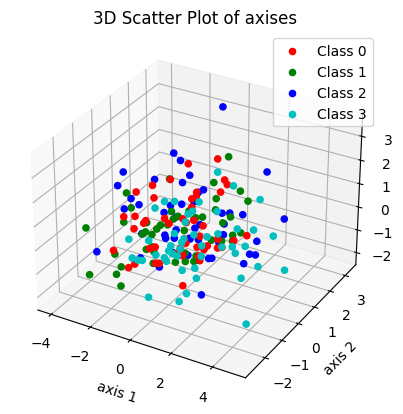

,axis1,axis2,axis3,axis4,axis5,label
0,0.013619,-0.354014,-0.535143,0.896591,0.695361,0
1,-1.227717,1.215887,-0.588730,-0.046747,0.521211,0
2,1.024588,1.619454,-1.233575,1.060102,0.753063,0
3,-1.622452,-1.090577,0.382201,0.456848,-0.181058,0
4,0.834282,-1.504633,0.221069,-0.222926,0.098286,0
...,...,...,...,...,...,...
191,0.762773,-1.093802,-0.773340,0.005200,-0.673362,3
192,0.292554,1.532189,-1.069253,-0.970368,0.533824,3
193,1.904430,-1.687074,0.019837,-0.409462,0.292408,3
194,-0.302053,0.096642,-0.643855,-0.626315,-0.019890,3


In [901]:
# 데이터를 DataFrame으로 생성
df = pd.concat([principalDF, labelDF], axis=1)
plotDF3D(df ,4)
df

In [902]:
LDA_DF = pd.concat([pd.DataFrame(LDATransform(principalDF, labelDF, 3, "eigen")), labelDF], axis=1)

In [903]:
LDA_DF.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [910]:
scaler = StandardScaler()
scaler.fit(LDA_DF.loc[:, :"axis3"])
LDA_DF_Scaled = pd.concat([pd.DataFrame(scaler.transform(LDA_DF.loc[:, :"axis3"])), labelDF], axis=1)
LDA_DF_Scaled.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [905]:
np.save(f"./data/raw/dataframe_raw_{experimentIdx}", LDA_DF)

In [906]:
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, cross_validate

In [907]:
# SVM, kernel = 'linear'로 선형분리 진행
svm_clf =svm.SVC(kernel = 'linear', random_state=100)

# 교차검증
scores = cross_val_score(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv = 5)

pd.DataFrame(cross_validate(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv =5))

print('교차검증 평균: ', scores.mean())

# SVM, kernel = 'rbf'로 비선형분리 진행
svm_clf = svm.SVC(kernel = 'rbf')

# 교차검증
scores = cross_val_score(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv = 5)
scores

pd.DataFrame(cross_validate(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv =5))

print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.39794871794871794
교차검증 평균:  0.4182051282051281
